# Compute whole-brain signal and noise-correlation matrices using beta series activations (trial-to-trial activation estimates)

In [2]:
import numpy as np
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import hcp_utils as hcp
import tools
import nilearn.plotting as plotting
from importlib import reload
tools = reload(tools)
import wbplot
import pandas as pd
import matplotlib.image as img 
import statsmodels.sandbox.stats.multicomp as mc

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


#### Set up basic parameters

In [4]:
basedir = '/home/ti236/taku/multiTaskVAE/'

networkdef = np.loadtxt('/home/ti236/AnalysisTools/ColeAnticevicNetPartition/cortex_parcel_network_assignments.txt')
# need to subtract one to make it compatible for python indices
indsort = np.loadtxt('/home/ti236/AnalysisTools/ColeAnticevicNetPartition/cortex_community_order.txt',dtype=int) - 1 
indsort.shape = (len(indsort),1)

# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[indsort]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

glasserfilename = '/home/ti236/AnalysisTools/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = np.squeeze(nib.load(glasserfilename).get_data())
figuredir = basedir + 'docs/figures/task_rsa/'


#### split up sensorimotor from association network color palettes
color1, color2 = sns.color_palette(palette='Set2',n_colors=2)
associationnets = ['con','dan','lan','fpn','dmn','pmulti','none1','none2']
sensorimotornets = ['vis1','vis2','smn','aud']

roi_id = np.zeros((nParcels,))
tmp = {}
netcount = 0
for network in networkmappings:
    net = np.where(networkdef==networkmappings[network])[0]
    for roi in net:
        if network in associationnets:
            tmp[roi] = color1 #'r'
            roi_id[roi] = -1
        else:
            tmp[roi] = color2 #'b'
            roi_id[roi] = 1
    netcount += 1
    
roiColorsByNetwork = []
for roi in range(len(networkdef)):
    roiColorsByNetwork.append(tmp[roi])
    
# Set task ordering
unique_tasks = ['NoGo','Go','TheoryOfMind','VideoActions','VideoKnots','Math',
                'DigitJudgement','Objects','MotorImagery','FingerSimple','FingerSeq',
                'Verbal2Back','SpatialImagery','VerbGen','WordRead','Rest',
                'PermutedRules','SpatialMapEasy','SpatialMapMed','SpatialMapHard',
                'NatureMovie','AnimatedMovie','LandscapeMovie','UnpleasantScenes','PleasantScenes',
                'SadFaces','HappyFaces','Object2Back','IntervalTiming',
                'Prediction','PredictViol','PredictScram','VisualSearchEasy','VisualSearchMed','VisualSearchHard',
                'StroopIncon','StroopCon','MentalRotEasy','MentalRotMed','MentalRotHard',
                'BiologicalMotion','ScrambledMotion','RespAltEasy','RespAltMed','RespAltHard']

task_passivity = ['left','left','left','passive','passive','right',
                  'right','passive','passive','both','both',
                  'left','passive','passive','passive','passive',
                  'both','both','both','both',
                  'passive','passive','passive','left','left',
                  'right','right','right','right',
                  'left','left','left','left','left','left',
                  'both','both','right','right','right',
                  'right','right','both','both','both']

# sort tasks by passivity
unique_tasks = np.asarray(unique_tasks)
task_passivity = np.asarray(task_passivity)
unique_tasks2 = []
passivity_order = ['passive','left','right','both']
for i in passivity_order:
    ind = np.where(task_passivity==i)[0]
    unique_tasks2.extend(unique_tasks[ind])

unique_tasks = np.asarray(unique_tasks2)

<ipython-input-4-93bbc017af89>:35: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  glasser = np.squeeze(nib.load(glasserfilename).get_data())


In [ ]:
subIDs=['02','03','04','06','08','09','10','12','14','15','18','20','22','25','27','29','31','17','19','21','24','26','28','30']
sessIDs = ['a1','a2','b1','b2']
runs = range(1,9)

____

# Load in parcellated data

In [ ]:
tools = reload(tools)
data = {}
task_index = {}
for sub in subIDs:
    data[sub] = []
    task_index[sub] = []
    for sess in sessIDs:
        session = sub + '_' + sess
        for run in runs:
            tmpdat, tmpind = tools.loadTaskActivations(session,run,space='parcellated',model='betaseries')
            data[sub].extend(tmpdat.T)
            task_index[sub].extend(tmpind)
            
    data[sub] = np.asarray(data[sub])
    task_index[sub] = np.asarray(task_index[sub])
            

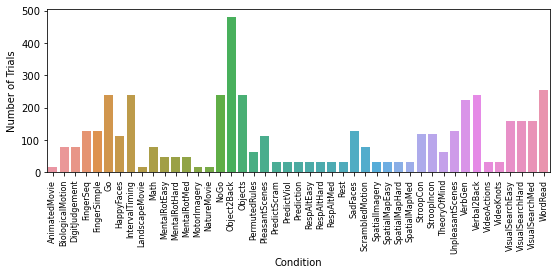

In [76]:
conditions = np.unique(task_index[sub])
num_trials_per_cond = {}
num_trials_per_cond['Condition'] = []
num_trials_per_cond['Number of Trials'] = []
for cond in conditions:
    for sub in subIDs:
        num_trials_per_cond['Number of Trials'].append(np.sum(task_index[sub]==cond))
        num_trials_per_cond['Condition'].append(cond)
        
tmpdf = pd.DataFrame(num_trials_per_cond)
plt.figure(figsize=(9,3))
ax = sns.barplot(x="Condition",y="Number of Trials",data=tmpdf)
plt.xticks(fontsize=8,rotation=90);

# Measure 'signal correlations'

In [208]:
tmpmat = np.zeros((nParcels,nParcels,2)) # r and p-values
for x in range(nParcels):
    for y in range(nParcels):
        if x>=y: continue
        r, p = stats.pearsonr(parcel_signals[x,:],parcel_signals[y,:])
        tmpmat[x,y,0] = r
        tmpmat[x,y,1] = p


In [257]:
signal_corr = np.zeros((nParcels,nParcels,len(subIDs)))
i = 0
for sub in subIDs:
    parcel_signals = []
    j = 0
    for cond in conditions:
        tmp_taskind = np.where(task_index[sub]==cond)[0]
        parcel_signals.append(np.mean(data[sub][tmp_taskind,:],axis=0))        
        j += 1
    # Compute the 'average' of signals across task conditions for each parcel
    parcel_signals = np.asarray(parcel_signals).T
    #
    tmpmat = np.corrcoef(parcel_signals)
    tmat = tmpmat2*np.sqrt((parcel_signals.shape[1]-2)/(1-tmpmat2**2))
    pval = stats.t.sf(np.abs(tmat), parcel_signals.shape[1]-2)*2
    h0,qs = mc.fdrcorrection0(pval[triu_ind])
    thresh_mat = np.zeros((nParcels,nParcels))
    thresh_mat[triu_ind] = np.multiply(tmpmat[triu_ind],h0)
    thresh_mat = thresh_mat + thresh_mat.T
    # Compute signal correlations, i.e., 'brain co-activations'
#     signal_corr[:,:,i] = np.corrcoef(parcel_signals)
    signal_corr[:,:,i] = tmpmat
    np.fill_diagonal(signal_corr[:,:,i],0)
    signal_corr[:,:,i] = np.arctanh(signal_corr[:,:,i])

    i += 1

<ipython-input-257-c116fc933252>:14: RuntimeWarning: divide by zero encountered in true_divide
  tmat = tmpmat2*np.sqrt((parcel_signals.shape[1]-2)/(1-tmpmat2**2))


## Visualize signal correlation matrix

Text(0.5, 11.8752, 'Parcel')

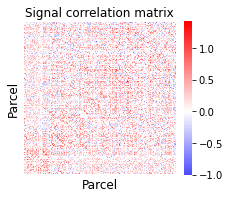

In [226]:
avg_sig_mat = np.mean(signal_corr,axis=2)
np.fill_diagonal(avg_sig_mat,0)
plt.figure(figsize=(3,3))
sig_mat_sorted = avg_sig_mat[indsort,indsort.T]
ax = sns.heatmap(sig_mat_sorted,square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.title('Signal correlation matrix',fontsize=12);
plt.xticks([])
plt.yticks([])
plt.ylabel('Parcel',fontsize=12)
plt.xlabel('Parcel',fontsize=12)

# Measure noise correlation matrices

In [229]:
noise_corr = np.zeros((nParcels,nParcels,len(conditions),len(subIDs)))
triu_ind = np.triu_indices(nParcels,k=1)
i = 0
for sub in subIDs:
    parcel_signals = []
    j = 0
    for cond in conditions:
        tmp_taskind = np.where(task_index[sub]==cond)[0]
        tmpmat = np.corrcoef(data[sub][tmp_taskind,:].T)
#         tmat = tmpmat*np.sqrt((len(tmp_taskind)-2)/(1-tmpmat**2))
#         pval = stats.t.sf(np.abs(tmat), len(tmp_taskind)-2)*2
#         # Compute threshold
#         h0,qs = mc.fdrcorrection0(pval[triu_ind])
#         thresh_mat = np.zeros((nParcels,nParcels))
#         thresh_mat[triu_ind] = np.multiply(tmpmat[triu_ind],h0)
#         thresh_mat = thresh_mat + thresh_mat.T
        noise_corr[:,:,j,i] = tmpmat
        np.fill_diagonal(noise_corr[:,:,j,i],0)
        noise_corr[:,:,j,i] = np.arctanh(noise_corr[:,:,j,i])
        j += 1
    i += 1

## Visualize the averaged noise correlation matrix

Text(0.5, 11.8752, 'Parcel')

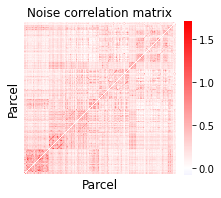

In [230]:
avg_noise_mat = np.mean(np.mean(noise_corr,axis=2),axis=2)
np.fill_diagonal(avg_noise_mat,0)
plt.figure(figsize=(3,3))
noise_mat_sorted = avg_noise_mat[indsort,indsort.T]
ax = sns.heatmap(noise_mat_sorted,square=True,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.title('Noise correlation matrix',fontsize=12);
plt.xticks([])
plt.yticks([])
plt.ylabel('Parcel',fontsize=12)
plt.xlabel('Parcel',fontsize=12)

## Replicate Ito et al. (2020) PLOS CB paper (correlation reductions from rest to task)

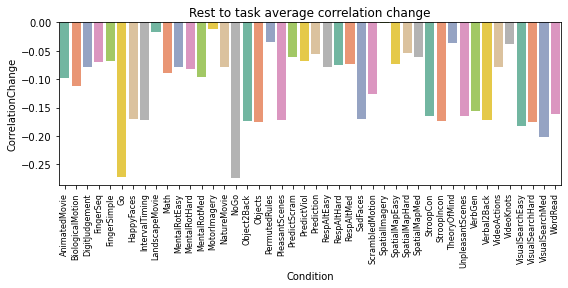

In [279]:
tmpdf = {}
tmpdf['Condition'] = []
tmpdf['CorrelationChange'] = []
rest_ind = np.where(conditions=='Rest')[0][0]
for i in range(len(conditions)):
    if conditions[i]=='Rest': continue
    tmpdf['CorrelationChange'].append(np.nanmean(avg_noisecorr[:,:,i] - avg_noisecorr[:,:,rest_ind]))
    tmpdf['Condition'].append(conditions[i])
tmpdf = pd.DataFrame(tmpdf)
plt.figure(figsize=(9,3))
plt.title('Rest to task average correlation change', fontsize=12)
ax = sns.barplot(x="Condition",y="CorrelationChange",data=tmpdf,palette="Set2")
plt.xticks(fontsize=8,rotation=90);

## For each noise correlation matrix compute the difference of that correlation matrix relative to the rest of the correlation matrices, and compare that to the signal correlation matrix

#### Hypothesis: Differences in noise correlation matrices will be negatively correlated with signal correlations

In [282]:
triu_ind = np.triu_indices(nParcels,k=1)
# Average across subjects
df_signoise = {}
df_signoise['Correlation'] = []
df_signoise['Percent'] = []
df_signoise['Condition'] = []
df_signoise['Type'] = []
avg_noisecorr = np.mean(noise_corr,axis=3)
avg_sigcorr = np.mean(signal_corr,axis=2)
# t, p = stats.ttest_1samp(signal_corr,0,axis=2)
# h0, qs = mc.fdrcorrection0(p[triu_ind])
# avg_sigcorr = np.zeros((nParcels,nParcels))
# avg_sigcorr[triu_ind] = np.multiply(np.mean(signal_corr,axis=2)[triu_ind],h0)
# avg_sigcorr = avg_sigcorr + avg_sigcorr.T

signal_noise_corr_comparison = []
rest_ind = np.where(conditions=='Rest')[0][0]
for i in range(len(conditions)):
    if conditions[i] == 'Rest': continue
    other_cond = np.where(np.arange(len(conditions))!=i)[0]
    
    noise_corr_diff = avg_noisecorr[:,:,i] - avg_noisecorr[:,:,rest_ind]
    tmp = np.mean(np.multiply(noise_corr_diff[triu_ind],avg_sigcorr[triu_ind])<0)
    r, p = stats.spearmanr(noise_corr_diff[triu_ind],avg_sigcorr[triu_ind])
    df_signoise['Type'].append('All')
    df_signoise['Percent'].append(tmp)
    df_signoise['Condition'].append(conditions[i])
    df_signoise['Correlation'].append(r)
    
    pos_ind = avg_sigcorr[triu_ind]>0
    tmp = np.mean(np.multiply(noise_corr_diff[triu_ind][pos_ind],avg_sigcorr[triu_ind][pos_ind])<0)
    r, p = stats.spearmanr(noise_corr_diff[triu_ind][pos_ind],avg_sigcorr[triu_ind][pos_ind])
    df_signoise['Type'].append('PositiveSignalCorr')
    df_signoise['Percent'].append(tmp)
    df_signoise['Condition'].append(conditions[i])
    df_signoise['Correlation'].append(r)


    neg_ind = avg_sigcorr[triu_ind]<0
    tmp = np.mean(np.multiply(noise_corr_diff[triu_ind][neg_ind],avg_sigcorr[triu_ind][neg_ind])<0)
    r, p = stats.spearmanr(noise_corr_diff[triu_ind][neg_ind],avg_sigcorr[triu_ind][neg_ind])
    df_signoise['Type'].append('NegativeSignalCorr')
    df_signoise['Percent'].append(tmp)
    df_signoise['Condition'].append(conditions[i])
    df_signoise['Correlation'].append(r)

df_signoise = pd.DataFrame(df_signoise)

#### Plot differences across conditions

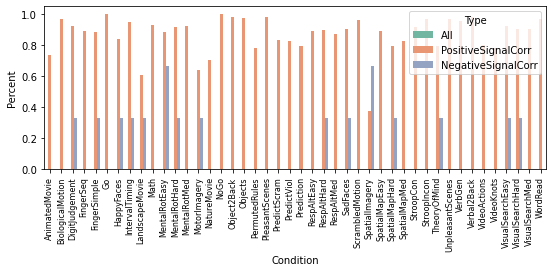

In [270]:
plt.figure(figsize=(9,3))
ax = sns.barplot(x="Condition",y="Percent",hue="Type",data=df_signoise,palette="Set2")
plt.xticks(fontsize=8,rotation=90);

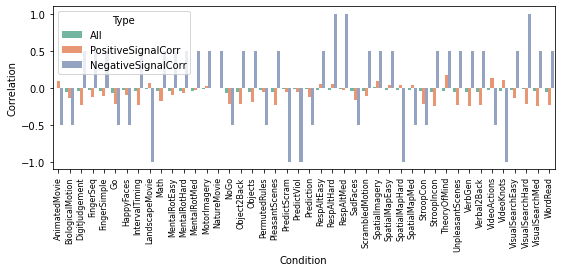

In [276]:
plt.figure(figsize=(9,3))
ax = sns.barplot(x="Condition",y="Correlation",hue="Type",data=df_signoise,palette="Set2")
plt.xticks(fontsize=8,rotation=90);

# What brain regions are involved in noise correlation *increases*?

In [283]:
triu_ind = np.triu_indices(nParcels,k=1)
# Average across subjects
df_signoise = {}
df_signoise['Correlation'] = []
df_signoise['Percent'] = []
df_signoise['Condition'] = []
df_signoise['Type'] = []
avg_noisecorr = np.mean(noise_corr,axis=3)
avg_sigcorr = np.mean(signal_corr,axis=2)
# t, p = stats.ttest_1samp(signal_corr,0,axis=2)
# h0, qs = mc.fdrcorrection0(p[triu_ind])
# avg_sigcorr = np.zeros((nParcels,nParcels))
# avg_sigcorr[triu_ind] = np.multiply(np.mean(signal_corr,axis=2)[triu_ind],h0)
# avg_sigcorr = avg_sigcorr + avg_sigcorr.T

signal_noise_corr_comparison = []
rest_ind = np.where(conditions=='Rest')[0][0]
for i in range(len(conditions)):
    if conditions[i] == 'Rest': continue
    other_cond = np.where(np.arange(len(conditions))!=i)[0]
    
    noise_corr_diff = avg_noisecorr[:,:,i] - avg_noisecorr[:,:,rest_ind]
    tmp = np.mean(np.multiply(noise_corr_diff[triu_ind],avg_sigcorr[triu_ind])<0)
    r, p = stats.spearmanr(noise_corr_diff[triu_ind],avg_sigcorr[triu_ind])
    df_signoise['Type'].append('All')
    df_signoise['Percent'].append(tmp)
    df_signoise['Condition'].append(conditions[i])
    df_signoise['Correlation'].append(r)
    
    pos_ind = noise_corr_diff[triu_ind]>0
    tmp = np.mean(np.multiply(noise_corr_diff[triu_ind][pos_ind],avg_sigcorr[triu_ind][pos_ind])<0)
    r, p = stats.spearmanr(noise_corr_diff[triu_ind][pos_ind],avg_sigcorr[triu_ind][pos_ind])
    df_signoise['Type'].append('PositiveNoiseCorr')
    df_signoise['Percent'].append(tmp)
    df_signoise['Condition'].append(conditions[i])
    df_signoise['Correlation'].append(r)


    neg_ind = noise_corr_diff[triu_ind]<0
    tmp = np.mean(np.multiply(noise_corr_diff[triu_ind][neg_ind],avg_sigcorr[triu_ind][neg_ind])<0)
    r, p = stats.spearmanr(noise_corr_diff[triu_ind][neg_ind],avg_sigcorr[triu_ind][neg_ind])
    df_signoise['Type'].append('NegativeNoiseCorr')
    df_signoise['Percent'].append(tmp)
    df_signoise['Condition'].append(conditions[i])
    df_signoise['Correlation'].append(r)

df_signoise = pd.DataFrame(df_signoise)

#### Plot differences across conditions

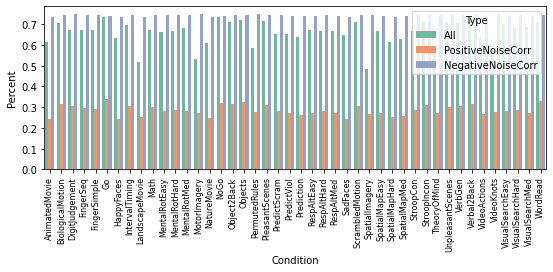

In [284]:
plt.figure(figsize=(9,3))
ax = sns.barplot(x="Condition",y="Percent",hue="Type",data=df_signoise,palette="Set2")
plt.xticks(fontsize=8,rotation=90);

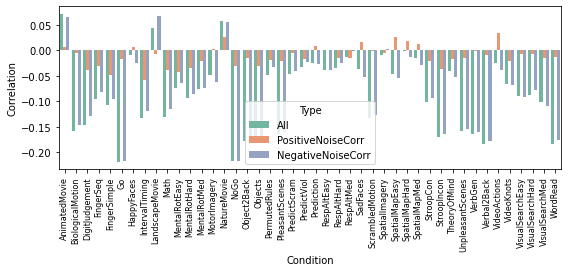

In [285]:
plt.figure(figsize=(9,3))
ax = sns.barplot(x="Condition",y="Correlation",hue="Type",data=df_signoise,palette="Set2")
plt.xticks(fontsize=8,rotation=90);

## Perform by subject

In [253]:
# Average across subjects
df_signoise = {}
df_signoise['Subject'] = []
df_signoise['Correlation'] = []
df_signoise['Condition'] = []
df_signoise['Type'] = []
df_signoise['Percent'] = []
triu_ind = np.triu_indices(nParcels,k=1)

rest_ind = np.where(conditions=='Rest')[0][0]
for s in range(len(subIDs)):
    for i in range(len(conditions)):
        if conditions[i] == 'Rest': continue
#         other_cond = np.where(np.arange(len(conditions))!=i)[0]
        noise_corr_diff = noise_corr[:,:,i,s] - noise_corr[:,:,rest_ind,s]

        tmp = np.mean(np.multiply(noise_corr_diff[triu_ind],signal_corr[:,:,s][triu_ind])<0)
        r, p = stats.spearmanr(noise_corr_diff[triu_ind],signal_corr[:,:,s][triu_ind])
        df_signoise['Type'].append('All')
        df_signoise['Percent'].append(tmp)
        df_signoise['Correlation'].append(r)
        df_signoise['Condition'].append(conditions[i])
        df_signoise['Subject'].append(subIDs[s])
        
        pos_ind = avg_sigcorr[triu_ind]>0
        tmp = np.mean(np.multiply(noise_corr_diff[triu_ind][pos_ind],signal_corr[:,:,s][triu_ind][pos_ind])<0)
        r, p = stats.spearmanr(noise_corr_diff[triu_ind][pos_ind],signal_corr[:,:,s][triu_ind][pos_ind])
        df_signoise['Type'].append('PositiveSignalCorr')
        df_signoise['Percent'].append(tmp)
        df_signoise['Correlation'].append(r)
        df_signoise['Condition'].append(conditions[i])
        df_signoise['Subject'].append(subIDs[s])
        
        neg_ind = avg_sigcorr[triu_ind]<0
        tmp = np.mean(np.multiply(noise_corr_diff[triu_ind][neg_ind],signal_corr[:,:,s][triu_ind][neg_ind])<0)
        r, p = stats.spearmanr(noise_corr_diff[triu_ind][neg_ind],signal_corr[:,:,s][triu_ind][neg_ind])
        df_signoise['Type'].append('NegativeSignalCorr')
        df_signoise['Percent'].append(tmp)
        df_signoise['Correlation'].append(r)
        df_signoise['Condition'].append(conditions[i])
        df_signoise['Subject'].append(subIDs[s])
        

df_signoise = pd.DataFrame(df_signoise)

#### Plot differences across conditions

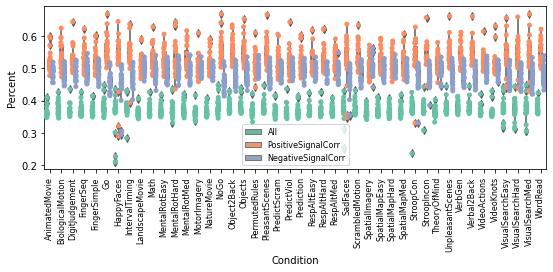

In [255]:
plt.figure(figsize=(9,3))
ax = sns.boxplot(x="Condition",y="Percent",hue="Type",data=df_signoise,palette='Set2')
sns.stripplot(x="Condition",y="Percent",hue="Type",data=df_signoise,dodge=True,palette='Set2')
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3],fontsize=8)
plt.xticks(fontsize=8,rotation=90);


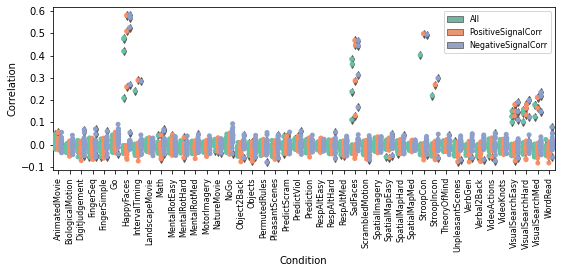

In [256]:
plt.figure(figsize=(9,3))
ax = sns.boxplot(x="Condition",y="Correlation",hue="Type",data=df_signoise,palette='Set2')
sns.stripplot(x="Condition",y="Correlation",hue="Type",data=df_signoise,dodge=True,palette='Set2')
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3],fontsize=8)
plt.xticks(fontsize=8,rotation=90);


In [269]:
for cond in conditions:
    t, p = stats.ttest_1samp(df_signoise.Correlation[df_signoise.Condition==cond],0)
    avg = df_signoise.Correlation[df_signoise.Condition==cond].mean()
    print('Avg corr:', avg, '| t =', t,'| p =', p)


Avg corr: -0.1382597017574743 | t = -0.7563532975990558 | p = 0.5283896946186959
Avg corr: -0.22786350306757885 | t = -1.649850532107846 | p = 0.24075612317672795
Avg corr: 0.07467522483683627 | t = 0.3393889064657843 | p = 0.7666415771236377
Avg corr: 0.1172149278037549 | t = 0.607512909363743 | p = 0.6053006720282427
Avg corr: 0.11616458321599898 | t = 0.6014200172305976 | p = 0.6086503417826784
Avg corr: -0.2623823129852636 | t = -2.0691981146703236 | p = 0.1744039670130127
Avg corr: -0.20851195572343353 | t = -1.4145937947438285 | p = 0.29279817988652973
Avg corr: 0.07500610613871857 | t = 0.34293445529624134 | p = 0.7643384427143778
Avg corr: -0.3172653021118009 | t = -0.9276604299903681 | p = 0.45151599616638316
Avg corr: 0.0942860724177114 | t = 0.4570674548864731 | p = 0.6924673550400775
Avg corr: 0.12069551348762379 | t = 0.6334141571508966 | p = 0.5912362467405088
Avg corr: 0.1272731045039688 | t = 0.6820466780188854 | p = 0.5656007122907389
Avg corr: 0.14660280935261857 | t 

/gpfs/loomis/project/murray/ti236/conda_envs/taku/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs/loomis/project/murray/ti236/conda_envs/taku/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/gpfs/loomis/project/murray/ti236/conda_envs/taku/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gpfs/loomis/project/murray/ti236/conda_envs/taku/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/gpfs/loomis/project/murray/ti236/conda_envs/taku/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid valu